In [4]:
import os
import io
import regex as re
from collections import Counter 

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
rc('animation', html='html5')

import umap
import hdbscan
import fasttext


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dependencies

Make sure you  install hdbscan and umap-learn with conda to avoid dependencies issues.

Install fasttext with pip (conda version is outdates) and download the language models you are going to use.

Model for language identification is found at: 
https://fasttext.cc/docs/en/language-identification.html

Model for different languages are found at:
https://fasttext.cc/docs/en/crawl-vectors.html


## Load Linkedin contacts data

You can ask for a copy at: 
https://www.linkedin.com/psettings/member-data

In [5]:
df = pd.read_csv('../data/Connections.csv')
print(df.shape)
df.head()

(601, 2)


,Position,Company
0,Recruitment Hero,Hero Consulting GmbH
1,Gründer,SimpliOffice
2,"Founder, Owner, Interim Recruiter",Kooku Recruiting Partners
3,Senior Software Development Engineer,Accenture
4,Manager - Digital Team - North Germany,Darwin Recruitment


## Cleanup of Position strings

In [6]:
def expand_abbreviation(text):
    """Expand common abreviations into the full text"""
    translations = {
        "cto": "chief technology officer",
        "ceo": "chief executive officer",
        "rrhh": "recursos humanos",
        "rh": "recursos humanos",
        "hr": "human resources",
        "qa": "quality assurance",
        "sr": "senior",
        "jr": "junior"
    }
    for abb, sub in translations.items():
        text = re.sub(r'\b%s\b' % re.escape(abb), sub, text)
    return text

def clean_characters(text):
    """Remove non letter characters and make string lowercase"""
    return re.sub(r'\PL+', ' ', text).lower().strip()

df.dropna(subset=['Position'], inplace=True)
df['clean_title'] = df.Position.apply(clean_characters).apply(expand_abbreviation)
df = df[df.clean_title != '']
print(df.shape)
df.head()

(587, 3)


,Position,Company,clean_title
0,Recruitment Hero,Hero Consulting GmbH,recruitment hero
1,Gründer,SimpliOffice,gründer
2,"Founder, Owner, Interim Recruiter",Kooku Recruiting Partners,founder owner interim recruiter
3,Senior Software Development Engineer,Accenture,senior software development engineer
4,Manager - Digital Team - North Germany,Darwin Recruitment,manager digital team north germany


## Predict language

In [7]:
langid_model = fasttext.load_model('../data/lid.176.ftz')
lang_predictions, _ = langid_model.predict(df.clean_title.values.tolist())

df['lang'] = list(map(lambda x: x[0].replace('__label__',''), lang_predictions))
df.lang.value_counts()

en     502
es      63
it       6
de       6
pt       5
fr       2
cs       1
ceb      1
sv       1
Name: lang, dtype: int64

In [8]:
keep_langs = ['en', 'es']
df = df.loc[df.lang.isin(keep_langs), ['clean_title', 'lang']]

print(df.shape)
df.head()

(565, 2)


,clean_title,lang
0,recruitment hero,en
2,founder owner interim recruiter,en
3,senior software development engineer,en
4,manager digital team north germany,en
5,co founder chief executive officer,en


In [9]:
def remove_stopwords(txt, stopwords_list):
    return ' '.join([word for word in txt.split() if word not in stopwords_list])

sw_en = stopwords.words('english')
sw_es = stopwords.words('spanish')
df.loc[df.lang == 'en', 'clean_title'] = df.clean_title.apply(lambda txt: remove_stopwords(txt, sw_en))
df.loc[df.lang == 'es', 'clean_title'] = df.clean_title.apply(lambda txt: remove_stopwords(txt, sw_es))

# Online vectorization

Load language models into memory and vectorize on the run. Appropriate for production services running on the cloud.

In [10]:
# en_model = fasttext.load_model("../data/cc.en.300.bin")
# en_vectors = en_model.get_sentence_vector( df[df.lang == 'en'].clean_title.values.tolist() )

# Vectorize only what we need

Export the vocabulary to a text file and vectorize with fasttext, then load the vectors.

        fasttext print-sentence-vectors data/cc.es.300.bin < data/es_strings.txt > data/es_vectors.txt


In [11]:
# Save strings to vectorize
df_en = df[df.lang == 'en']
df_es = df[df.lang == 'es']
df_en.clean_title.to_csv('../data/en_strings.txt', index=False)
df_es.clean_title.to_csv('../data/es_strings.txt', index=False)

In [12]:
def normalize_vectors(x):
    x /= np.linalg.norm(x, axis=1)[:, np.newaxis] + 1e-8
    return x

def center_vectors(x):
    x -= x.mean(axis=0)[np.newaxis, :]
    return normalize_vectors(x)

def load_vectors(file, norm=True, center=False):
    x = np.loadtxt(file)
    if norm:
        x = normalize_vectors(x)
    if center:
        x = center_vectors(x)
    return x

# Load vectors
en_vectors = load_vectors('../data/en_vectors.txt', center=True)
es_vectors = load_vectors('../data/es_vectors.txt', center=True)

In [13]:
assert(en_vectors.shape[0] == df_en.shape[0])
assert(es_vectors.shape[0] == df_es.shape[0])

## Align vectors in common vectorspace

In [14]:
def load_translation_matrix(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    x = np.zeros([n, d])
    for i, line in enumerate(fin):
        if i >= n:
            break
        tokens = line.rstrip().split(' ')
        v = np.array(tokens, dtype=float)
        x[i, :] = v

    return x

def translate_vectors(x, translation_matrix):
    return normalize_vectors(np.dot(x, translation_matrix.T))

translation_matrix = load_translation_matrix('../data/cc.es-en.vec-mat')
en_es_vectors = translate_vectors(es_vectors, translation_matrix)
vectors = np.concatenate((en_vectors, en_es_vectors))
df.index.name = 'index'
df.sort_values(['lang','index'], inplace=True)
df['vector_index'] = range(df.shape[0])

In [15]:
reducer = umap.UMAP(n_components=5, n_neighbors=30, random_state=42, min_dist=0.02)
embedding = reducer.fit_transform(vectors)
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=20)
df['c'] = clusterer.fit_predict(embedding)

In [16]:
labels = list(range(clusterer.labels_.max()+1))
for c in labels:
    category_corpus = " ".join(df[df.c == c].clean_title).split()
    if (len(category_corpus) <= 0):
        continue
    words, counts = zip(*Counter(category_corpus).most_common(5))
    labels[c] = " ".join(words)

df['label'] = df.c.apply(lambda x: labels[x])
df.loc[df.c == -1, 'label'] = ''

In [17]:
pd.crosstab(df.lang, df.c)

c,-1,0,1,2,3,4,5,6
lang,,,,,,,,
en,5,44,30,28,82,54,32,227
es,0,3,0,5,5,7,3,40


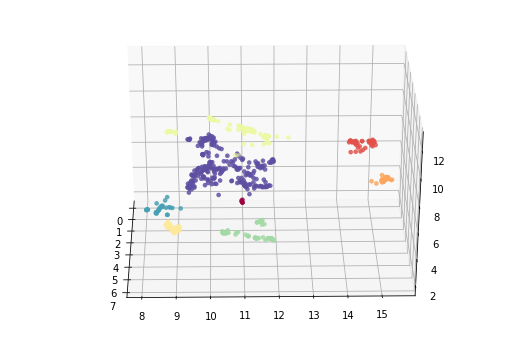

In [18]:
reducer = umap.UMAP(n_components=3, n_neighbors=30, random_state=42, min_dist=0.02)
embedding = reducer.fit_transform(vectors)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

def init_graph():
    graph = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c=df.c, label=df.label, alpha=0.6, linewidth=0, cmap='Spectral')

def update_graph(num):
    ax.view_init(30, num)

ani = animation.FuncAnimation(fig, update_graph, 360, init_func=init_graph, interval=20, blit=False)
ani